In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import PowerNorm, LogNorm
import scipy.ndimage

import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.simplefilter("ignore", category=AstropyWarning)

import os
import sys

module_path = os.path.abspath("./../../module")
sys.path.append(module_path)
import redh3p as rhp
import redh3p_v2 as rhp2

spec_dir = os.path.abspath("./../spec") + "/"
scam_dir = os.path.abspath("./../scam") + "/"
plot_dir = os.path.abspath("./../plots") + "/"

fits_path = scam_dir + "jun02*"

scam = rhp.read_fits(path=fits_path)

jupiter_scam = scam[119:773]

jupiter_spec_utc = []

sky_frame = [51, 59, 60, 72, 78, 79, 91, 103]

for fn in range(60, 104):
    if fn in sky_frame:
        continue
    else:
        spec_utc = rhp2.read_fits_header(spec_dir + "jun02*", "UTC", fn=fn)
        jupiter_spec_utc.append(spec_utc)

jupiter_spec_utc = np.array(jupiter_spec_utc)


def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.degrees(np.arctan2(y, x))
    return (rho, phi)


def pol2cart(rho, phi):
    x = rho * np.cos(np.radians(phi))
    y = rho * np.sin(np.radians(phi))
    return (x, y)


def slit_to_lat_long(x, y, jup_pixel_radius, jup_seangle, jup_posangle, jup_cml):
    jup_posangle2 = (720 - jup_posangle) % 360.0

    latit = np.zeros(5)
    longit = np.zeros(5)

    ccc = np.zeros(5)
    ppp = np.zeros(5)
    xxx = np.zeros(5)
    yyy = np.zeros(5)
    xxx = np.zeros(5)

    R = jup_pixel_radius

    # do a lat and long for each corner of pixel
    for corner in range(5):
        if corner == 0:
            x2 = x + 0.5
            y2 = y + 0.5
        if corner == 1:
            x2 = x + 0.5
            y2 = y - 0.5
        if corner == 2:
            x2 = x - 0.5
            y2 = y - 0.5
        if corner == 3:
            x2 = x - 0.5
            y2 = y + 0.5
        if corner == 4:
            x2 = x
            y2 = y

        # rotate the pixels into jovian rotational coordinates
        polar = cart2pol(x2, y2)
        new_polar = jup_posangle2 + polar[1]
        rect2 = pol2cart(polar[0], new_polar)

        xx = rect2[0]

        # stretch yy to become a sphere
        flattening = 0.06487
        losflattening = flattening * (1 - np.sin(np.radians(jup_seangle)))
        eq_po_ratio = 1 - losflattening

        yy = rect2[1] / eq_po_ratio

        pp = np.sqrt(xx**2 + yy**2)  # proper distance from centre

        if pp / R < 0.998 and pp >= 1e-5:
            cc = np.arcsin(pp / R)  # angular distance from centre

            ccc[corner] = cc
            ppp[corner] = pp
            xxx[corner] = xx
            yyy[corner] = yy

            lat_left = np.cos(cc) * np.sin(np.deg2rad(jup_seangle))
            lat_right = yy * np.sin(cc) * np.cos(np.deg2rad(jup_seangle)) / pp
            latit[corner] = np.arcsin(lat_left + lat_right)

            long_top = xx * np.sin(cc)
            long_bot1 = pp * np.cos(np.deg2rad(jup_seangle)) * np.cos(cc)
            long_bot2 = yy * np.sin(np.deg2rad(jup_seangle)) * np.sin(cc)

            longit[corner] = np.deg2rad(jup_cml) - np.arctan(
                long_top / (long_bot1 - long_bot2)
            )

    return np.rad2deg(latit)[4], np.rad2deg(longit)[4]

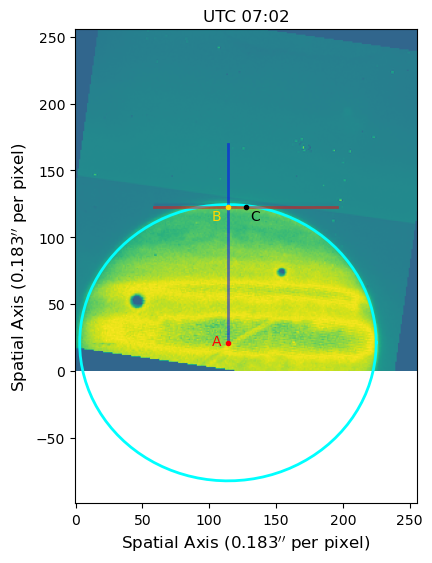

In [2]:
scam_second_1 = np.sum(scam[387:407], axis=0)
scam_second_2 = np.sum(scam[745:756], axis=0)

header = fits.open(scam_dir+'jun02i0750.fits', ignore_missing_end=True)[0].header

rotated_scam_second_1 = scipy.ndimage.rotate(np.sum(scam[387:407], axis=0), header['SLITANG'], reshape=False, )
rotated_scam_second_2 = scipy.ndimage.rotate(np.sum(scam[745:756], axis=0), header['SLITANG'], reshape=False, )

scam_pix_scale = 0.183 # Keck SCAM Pixel scale = 0.183"/pixel
spec_pix_scale = 0.1 # 0.288 (2-pixel slit) originally, rescaled to 0.1

jup_ang_diam = 40.59098 # from Horizons; 07:00 on 02 Jun 2017

jup_polar_radius = 66854 # from NASA Jupiter Fact Sheet

jup_ang_diam_add = jup_ang_diam * (1 + 2 * (800 / jup_polar_radius))

sub_earth_lat = -3.098 # from Horizons; 07:00 on 02 Jun 2017 

flattening = 0.06487 # from NASA Jupiter Fact Sheet
losflattening = flattening * (1 - np.sin(np.deg2rad(sub_earth_lat)))
eq_po_ratio = 1 - losflattening

jup_scam_radius = jup_ang_diam / scam_pix_scale / 2


u1 = 114
v1 = 21
a1 = round(jup_scam_radius) 
b1 = round(jup_scam_radius) * eq_po_ratio

u2 = 114  # x-position of the center
v2 = 42  # y-position of the center
a2 = round(jup_scam_radius)  # radius on the x-axis
b2 = round(jup_scam_radius) * eq_po_ratio

slit_x = header['SLITX']  # x-pos of the slit center
slit_y = header['SLITY']  # y-pos of the slit center

t = np.linspace(0, 2 * np.pi, 100)

fig = plt.figure(figsize=(8,8), tight_layout=True)

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(rotated_scam_second_1, origin="lower", norm=PowerNorm(gamma=0.3))
ax1.plot(u1 + a1 * np.cos(t), v1 + b1 * np.sin(t), "cyan", lw=2)
ax1.plot([59, 196], [slit_y, slit_y], "r-", lw=2, alpha=0.5)
ax1.plot([u1, u1], [v1, 170], "b-", lw=2, alpha=0.5)
ax1.plot(u1, v1, ms=6, c="red", marker=".")
ax1.plot(u1, slit_y, ms=6, c="gold", marker=".")
ax1.plot(slit_x, slit_y, ms=6, c="black", marker=".")
ax1.set_xlabel("Spatial Axis (0.183$^{\prime\prime}$ per pixel)", fontsize=12)
ax1.set_ylabel("Spatial Axis (0.183$^{\prime\prime}$ per pixel)", fontsize=12)
ax1.text(u1 - 12, v1 - 2, "A", color="r")
ax1.text(u1 - 12, slit_y - 10, "B", color="gold")
ax1.text(slit_x + 3, slit_y - 10, "C", color="black")
ax1.set_title("UTC 07:02", loc="center", fontsize=12)

# ax2.imshow(rotated_scam_second_2, origin="lower", norm=PowerNorm(gamma=0.3))
# ax2.plot(u2 + a2 * np.cos(t), v2 + b2 * np.sin(t), "cyan", lw=2)
# # ax2.plot([59, 196], [slit_y+20, slit_y+20], "r-", lw=2, alpha=0.5)
# ax2.plot([59, 196], [slit_y, slit_y], "r-", lw=2, alpha=0.5)
# ax2.plot([u2, u2], [v2, 170], "b-", lw=2, alpha=0.5)
# ax2.plot(u2, v2, ms=6, c="red", marker="*")
# ax2.plot(u2, slit_y, ms=6, c="gold", marker=".")
# ax2.plot(slit_x, slit_y, ms=6, c="black", marker=".")
# ax2.set_xlabel("Spatial Axis (0.183$^{\prime\prime}$ per pixel)", fontsize=12)
# ax2.text(u2 - 12, v2 - 2, "A", color="r")
# ax2.text(u2 - 12, slit_y - 10, "B", color="r")
# ax2.text(slit_x + 3, slit_y - 10, "C", color="r")
# ax2.set_title("b) UTC 07:38", loc="left", fontsize=12)

plt.savefig(plot_dir + "/scam_mapping", dpi=300, bbox_inches="tight")

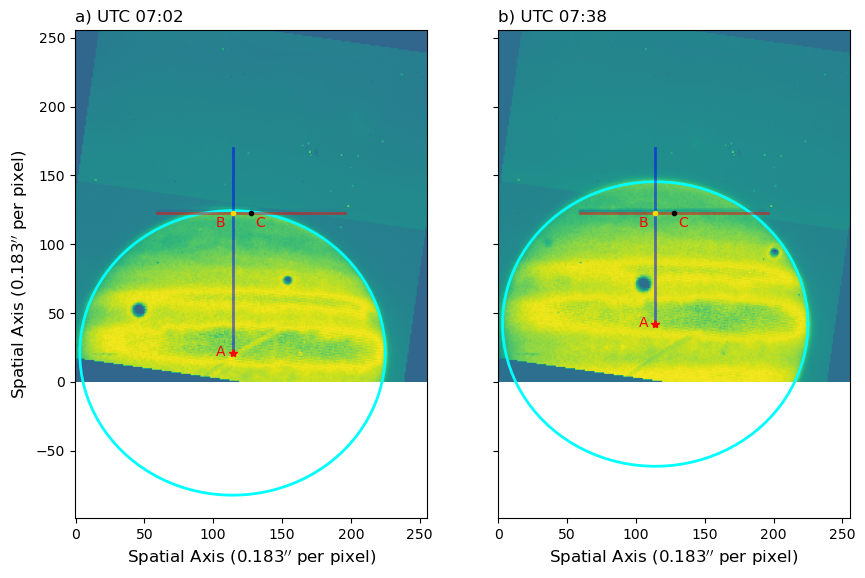

In [45]:
scam_second_1 = np.sum(scam[387:407], axis=0)
scam_second_2 = np.sum(scam[745:756], axis=0)

header = fits.open(scam_dir+'jun02i0750.fits', ignore_missing_end=True)[0].header

rotated_scam_second_1 = scipy.ndimage.rotate(np.sum(scam[387:407], axis=0), header['SLITANG'], reshape=False, )
rotated_scam_second_2 = scipy.ndimage.rotate(np.sum(scam[745:756], axis=0), header['SLITANG'], reshape=False, )

scam_pix_scale = 0.183 # Keck SCAM Pixel scale = 0.183"/pixel
spec_pix_scale = 0.1 # 0.288 (2-pixel slit) originally, rescaled to 0.1

jup_ang_diam = 40.59098 # from Horizons; 07:00 on 02 Jun 2017

jup_polar_radius = 66854 # from NASA Jupiter Fact Sheet

jup_ang_diam_add = jup_ang_diam * (1 + 2 * (800 / jup_polar_radius))

sub_earth_lat = -3.098 # from Horizons; 07:00 on 02 Jun 2017 

flattening = 0.06487 # from NASA Jupiter Fact Sheet
losflattening = flattening * (1 - np.sin(np.deg2rad(sub_earth_lat)))
eq_po_ratio = 1 - losflattening

jup_scam_radius = jup_ang_diam / scam_pix_scale / 2


u1 = 114
v1 = 21
a1 = round(jup_scam_radius) 
b1 = round(jup_scam_radius) * eq_po_ratio

u2 = 114  # x-position of the center
v2 = 42  # y-position of the center
a2 = round(jup_scam_radius)  # radius on the x-axis
b2 = round(jup_scam_radius) * eq_po_ratio

slit_x = header['SLITX']  # x-pos of the slit center
slit_y = header['SLITY']  # y-pos of the slit center

t = np.linspace(0, 2 * np.pi, 100)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 10))

ax1.imshow(rotated_scam_second_1, origin="lower", norm=PowerNorm(gamma=0.3))
ax1.plot(u1 + a1 * np.cos(t), v1 + b1 * np.sin(t), "cyan", lw=2)
ax1.plot([59, 196], [slit_y, slit_y], "r-", lw=2, alpha=0.5)
ax1.plot([u1, u1], [v1, 170], "b-", lw=2, alpha=0.5)
ax1.plot(u1, v1, ms=6, c="red", marker="*")
ax1.plot(u1, slit_y, ms=6, c="gold", marker=".")
ax1.plot(slit_x, slit_y, ms=6, c="black", marker=".")
ax1.set_xlabel("Spatial Axis (0.183$^{\prime\prime}$ per pixel)", fontsize=12)
ax1.set_ylabel("Spatial Axis (0.183$^{\prime\prime}$ per pixel)", fontsize=12)
ax1.text(u1 - 12, v1 - 2, "A", color="r")
ax1.text(u1 - 12, slit_y - 10, "B", color="r")
ax1.text(slit_x + 3, slit_y - 10, "C", color="r")
ax1.set_title("a) UTC 07:02", loc="left", fontsize=12)

ax2.imshow(rotated_scam_second_2, origin="lower", norm=PowerNorm(gamma=0.3))
ax2.plot(u2 + a2 * np.cos(t), v2 + b2 * np.sin(t), "cyan", lw=2)
# ax2.plot([59, 196], [slit_y+20, slit_y+20], "r-", lw=2, alpha=0.5)
ax2.plot([59, 196], [slit_y, slit_y], "r-", lw=2, alpha=0.5)
ax2.plot([u2, u2], [v2, 170], "b-", lw=2, alpha=0.5)
ax2.plot(u2, v2, ms=6, c="red", marker="*")
ax2.plot(u2, slit_y, ms=6, c="gold", marker=".")
ax2.plot(slit_x, slit_y, ms=6, c="black", marker=".")
ax2.set_xlabel("Spatial Axis (0.183$^{\prime\prime}$ per pixel)", fontsize=12)
ax2.text(u2 - 12, v2 - 2, "A", color="r")
ax2.text(u2 - 12, slit_y - 10, "B", color="r")
ax2.text(slit_x + 3, slit_y - 10, "C", color="r")
ax2.set_title("b) UTC 07:38", loc="left", fontsize=12)

# plt.savefig(plot_dir + "/scam_mapping.pdf", dpi=300, bbox_inches="tight")

In [10]:
flattening = 0.06487 # from NASA Jupiter Fact Sheet
losflattening = flattening * (1 - np.sin(np.deg2rad(sub_earth_lat)))
eq_po_ratio = 1 - losflattening
eq_po_ratio

0.9316241684804366

In [12]:
flattening * (1 - np.sin(np.deg2rad(sub_earth_lat)))

0.06837583151956338

In [13]:
ang_diam = 40.58867 # arcseconds
# ang_diam/(0.1) slit unit = 0.1 arcsec/pixel
limb_vel = 12.572 # V_equator of Jupiter in km/s

# vel_slope = limb_vel / (ang_diam/(0.1)/2)
vel_slope = limb_vel * 2 / (ang_diam / (0.1))

x = np.linspace(-150,150,301)
rot_rate = vel_slope * x

vel_slope

0.0619483220317394

In [16]:
slit_x, slit_y

(127.5, 122.5)

In [40]:
slit_y - v2, slit_y - v1, slit_x - u2

(80.5, 99.5, 13.5)

In [41]:
(slit_y - v1) * scam_pix_scale / spec_pix_scale

182.085

In [17]:
15 * 0.183 / 16

0.1715625

In [1]:
21 * 0.183 / 22

0.1746818181818182

In [21]:
ang_diam_first_scan = 40.59098 * (((66854 + 900) / 66854 - 1)*2 + 1)
r_first_scan = ang_diam_first_scan / (0.1) / 2
r_first_scan

208.41932725940103

In [29]:
x1 = 15.5 # slit_x - u1 13.5 or 15.5 depending on circle fit
y1 = 99.5 # slit_y - v1
x2 = 15.5 # slit_x - u2
y2 = 79.5 # slit_y - v2

ang_diam = 40.58867
r = ang_diam / (0.183) / 2

sub_sub_earth_lat = -3.098

north_pole_posangle = 0  # 16.62 #24.6399

from pandas import read_csv

cmlsel = read_csv("cml-sel.txt", sep="\s+", header=None)
cml = cmlsel[3].to_numpy()

lon_array = np.zeros([256, 256])
lat_array = np.zeros([256, 256])

# dat = rotated_scam_second_1 * 1.

for i in range(256):
    for j in range(256):
        xx = i - 112
        yy = j - 23

        lat, long = slit_to_lat_long(
            x=xx,
            y=yy,
            jup_pixel_radius=r,
            jup_seangle=sub_sub_earth_lat,
            jup_posangle=north_pole_posangle,
            jup_cml=cml[16],
        )

        lon_array[j][i] = long
        lat_array[j][i] = lat

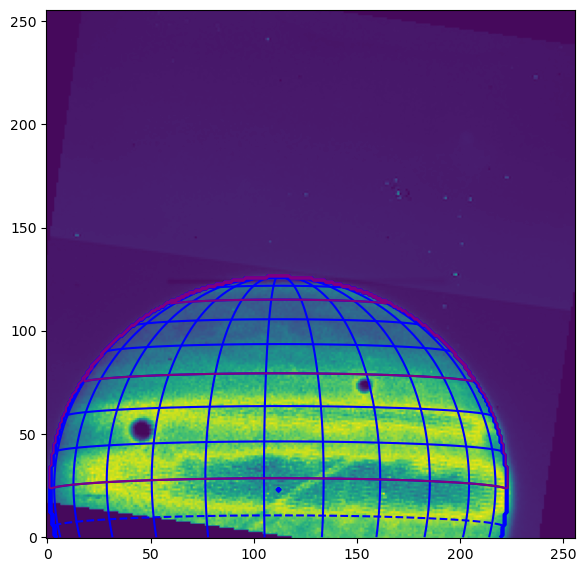

In [40]:
fig = plt.figure(figsize=(15, 10))

ax1 = plt.subplot(121)

ax1.imshow(rotated_scam_second_1, origin="lower")
ax1.contour(
    lon_array,
    np.linspace(0, 360, 25),
    colors="blue",
    #             extent=[-150, 150, 145.0669, 189.0669],
)
ax1.contour(
    lat_array,
    np.linspace(-90, 90, 19),
    colors="blue",
    #             extent=[-150, 150, 145.0669, 189.0669],
)

# ax2 = plt.subplot(122)

# ax2.imshow(lat_array, origin='lower')
ax1.contour(
    lat_array,
    np.linspace(-90, 90, 7),
    colors="purple",
    #             extent=[-150, 150, 145.0669, 189.0669],
)

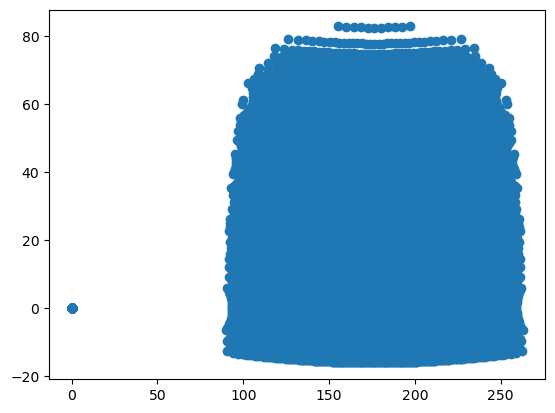

In [21]:
plt.scatter(lons, lats)

In [7]:
r

70.46644097222223

In [19]:
np.rad2deg(np.arctan2(20, 136))

8.36588612403259

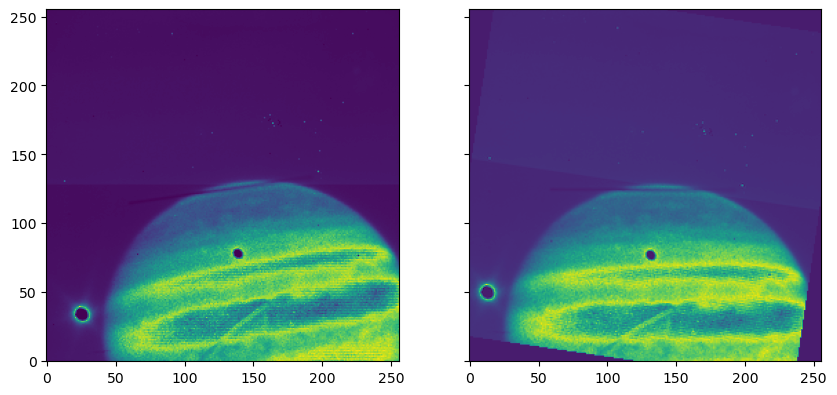

In [10]:
rotated_scam = scipy.ndimage.rotate(scam[119], np.rad2deg(np.arctan2(20, 136)), reshape=False)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 10))

ax1.imshow(scam[119], origin='lower')
# ax1.imshow(scam[358], origin="lower")

ax2.imshow(rotated_scam, origin="lower")

Text(0.0, 1.0, 'b) UTC 06:49')

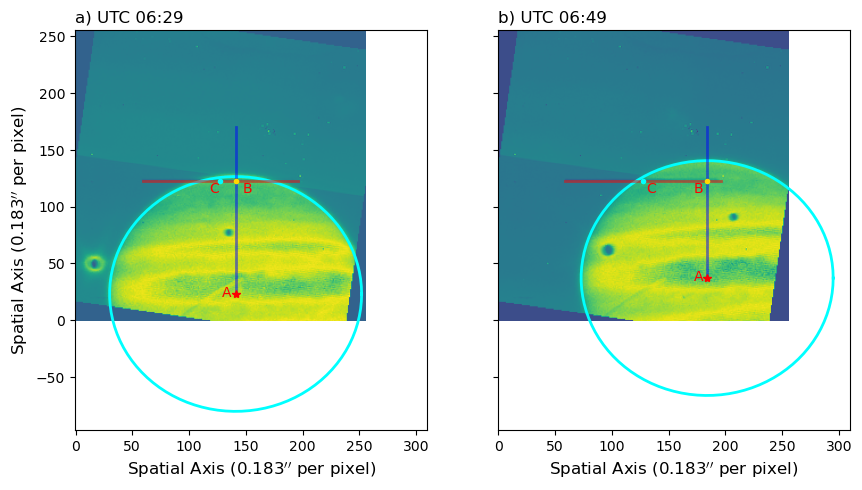

In [49]:
scam_second_1 = np.sum(scam[119:139], axis=0)
scam_second_2 = np.sum(scam[338:358], axis=0)

rotated_scam_second_1 = scipy.ndimage.rotate(np.sum(scam[119:139], axis=0), 8.1, reshape=False, )
rotated_scam_second_2 = scipy.ndimage.rotate(np.sum(scam[338:358], axis=0), 8.1, reshape=False, )

flattening = 0.06487
losflattening = flattening * (1 - np.sin(np.deg2rad(-3.098)))
eq_po_ratio = 1 - losflattening

u1 = 141
v1 = 23
a1 = 111
b1 = 111 * eq_po_ratio

u2 = 184  # x-position of the center
v2 = 37  # y-position of the center
a2 = 111  # radius on the x-axis
b2 = 111 * eq_po_ratio

slit_x = 127.5  # x-pos of the slit center
slit_y = 122.5  # y-pos of the slit center

t = np.linspace(0, 2 * np.pi, 100)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 10))

ax1.imshow(rotated_scam_second_1, origin="lower", norm=PowerNorm(gamma=0.3))
ax1.plot(u1 + a1 * np.cos(t), v1 + b1 * np.sin(t), "cyan", lw=2)
ax1.plot([59, 196], [slit_y, slit_y], "r-", lw=2, alpha=0.5)
ax1.plot([u1, u1], [v1, 170], "b-", lw=2, alpha=0.5)
ax1.plot(u1, v1, ms=6, c="red", marker="*")
ax1.plot(u1, slit_y, ms=6, c="gold", marker=".")
ax1.plot(slit_x, slit_y, ms=6, c="cyan", marker=".")
ax1.set_xlabel("Spatial Axis (0.183$^{\prime\prime}$ per pixel)", fontsize=12)
ax1.set_ylabel("Spatial Axis (0.183$^{\prime\prime}$ per pixel)", fontsize=12)
ax1.text(u1 - 12, v1 - 2, "A", color="r")
ax1.text(u1 + 6, slit_y - 10, "B", color="r")
ax1.text(slit_x - 10, slit_y - 10, "C", color="r")
ax1.set_title("a) UTC 06:29", loc="left", fontsize=12)

ax2.imshow(rotated_scam_second_2, origin="lower", norm=PowerNorm(gamma=0.3))
ax2.plot(u2 + a2 * np.cos(t), v2 + b2 * np.sin(t), "cyan", lw=2)
ax2.plot([59, 196], [slit_y, slit_y], "r-", lw=2, alpha=0.5)
ax2.plot([u2, u2], [v2, 170], "b-", lw=2, alpha=0.5)
ax2.plot(u2, v2, ms=6, c="red", marker="*")
ax2.plot(u2, slit_y, ms=6, c="gold", marker=".")
ax2.plot(slit_x, slit_y, ms=6, c="cyan", marker=".")
ax2.set_xlabel("Spatial Axis (0.183$^{\prime\prime}$ per pixel)", fontsize=12)
ax2.text(u2 - 12, v2 - 2, "A", color="r")
ax2.text(u2 - 12, slit_y - 10, "B", color="r")
ax2.text(slit_x + 3, slit_y - 10, "C", color="r")
ax2.set_title("b) UTC 06:49", loc="left", fontsize=12)

# plt.savefig(plot_dir + "/scam_mapping.pdf", dpi=400, bbox_inches="tight", facecolor="white")

In [17]:
40.591 / 0.183 / 2

110.90437158469946

In [48]:
15 * 0.183 / 16

0.1715625

In [50]:
x1 = slit_x - u1 # slit_x - u1 13.5 or 15.5 depending on circle fit
y1 = slit_y - v1 # slit_y - v1
x2 = slit_x - u2 # slit_x - u2
y2 = slit_y - v2 # slit_y - v2

x1, y1, x2, y2

(-13.5, 99.5, -56.5, 85.5)

In [51]:
(99.5 * 0.183) / 0.1

182.085

In [146]:
A = [60, 136]
B = [196, 156]

C = [136 - 30, 196 - 18]
D = [156 - 30, 60 - 18]


def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception("lines do not intersect")

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y


print(line_intersection((A, B), (C, D)))

(111.07197290431837, 143.51058425063505)


In [3]:
scam_new_1 = np.sum(scam[119:123], axis=0)
scam_new_2 = np.sum(scam[123:143], axis=0)
scam_new_3 = np.sum(scam[143:163], axis=0)
scam_new_4 = np.sum(scam[163:183], axis=0)
scam_new_5 = np.sum(scam[183:202], axis=0)

In [23]:
scam_utc = rhp2.read_fits_header(scam_dir + "jun02*", "UTC")
jupiter_scam_utc = np.array(scam_utc[119:773])

In [25]:
np.array(scam_utc[387:407])

array(['07:02:00.02', '07:02:04.27', '07:02:09.82', '07:02:14.12',
       '07:02:19.42', '07:02:24.12', '07:02:28.92', '07:02:33.72',
       '07:02:38.97', '07:02:43.77', '07:02:48.02', '07:02:52.62',
       '07:02:58.42', '07:03:02.62', '07:03:07.32', '07:03:15.17',
       '07:03:22.97', '07:03:27.62', '07:03:33.42', '07:03:37.57'],
      dtype='<U11')

In [6]:
np.array(scam_utc[119:123])

array(['06:28:28.34', '06:28:33.04', '06:28:37.24', '06:28:41.44'],
      dtype='<U11')

In [7]:
np.array(scam_utc[123:143])

array(['06:28:46.69', '06:28:51.94', '06:28:57.14', '06:29:02.34',
       '06:29:07.44', '06:29:11.54', '06:29:16.74', '06:29:21.89',
       '06:29:26.59', '06:29:32.39', '06:29:37.14', '06:29:41.29',
       '06:29:46.04', '06:29:50.69', '06:29:55.29', '06:30:02.04',
       '06:30:11.34', '06:30:15.44', '06:30:19.64', '06:30:24.29'],
      dtype='<U11')

In [8]:
np.array(scam_utc[143:163])

array(['06:30:28.99', '06:30:34.19', '06:30:38.89', '06:30:44.49',
       '06:30:49.74', '06:30:53.89', '06:30:58.49', '06:31:02.69',
       '06:31:08.34', '06:31:12.59', '06:31:17.74', '06:31:22.39',
       '06:31:26.54', '06:31:31.69', '06:31:36.34', '06:31:42.99',
       '06:31:50.74', '06:31:55.44', '06:32:00.49', '06:32:06.24'],
      dtype='<U11')

In [9]:
np.array(scam_utc[163:183])

array(['06:32:11.39', '06:32:16.44', '06:32:20.49', '06:32:25.19',
       '06:32:30.34', '06:32:34.99', '06:32:40.04', '06:32:44.14',
       '06:32:49.34', '06:32:54.99', '06:32:59.09', '06:33:03.84',
       '06:33:08.44', '06:33:13.19', '06:33:18.84', '06:33:25.64',
       '06:33:32.84', '06:33:37.99', '06:33:42.24', '06:33:47.85'],
      dtype='<U11')

In [10]:
np.array(scam_utc[183:202])

array(['06:33:53.05', '06:33:57.30', '06:34:02.55', '06:34:07.30',
       '06:34:11.85', '06:34:17.20', '06:34:21.70', '06:34:27.30',
       '06:34:32.00', '06:34:36.05', '06:34:40.80', '06:34:45.45',
       '06:34:49.60', '06:34:55.30', '06:35:00.45', '06:35:07.25',
       '06:35:16.10', '06:35:20.75', '06:35:25.45'], dtype='<U11')

In [11]:
np.array(scam_utc[202:221])

array(['06:35:31.15', '06:35:35.35', '06:35:39.95', '06:35:44.65',
       '06:35:49.30', '06:35:53.90', '06:35:59.10', '06:36:05.35',
       '06:36:11.00', '06:36:15.05', '06:36:21.25', '06:36:25.55',
       '06:36:30.15', '06:36:34.80', '06:36:39.40', '06:36:45.55',
       '06:36:53.90', '06:39:05.50', '06:39:10.70'], dtype='<U11')

In [23]:
jupiter_scam_utc[268:288]

array(['07:02:00.02', '07:02:04.27', '07:02:09.82', '07:02:14.12',
       '07:02:19.42', '07:02:24.12', '07:02:28.92', '07:02:33.72',
       '07:02:38.97', '07:02:43.77', '07:02:48.02', '07:02:52.62',
       '07:02:58.42', '07:03:02.62', '07:03:07.32', '07:03:15.17',
       '07:03:22.97', '07:03:27.62', '07:03:33.42', '07:03:37.57'],
      dtype='<U11')

In [29]:
np.array(scam_utc[745:756])

array(['07:38:04.74', '07:38:09.54', '07:38:14.19', '07:38:18.39',
       '07:38:23.14', '07:38:29.39', '07:38:34.14', '07:38:45.69',
       '07:38:51.44', '07:38:56.19', '07:39:00.34'], dtype='<U11')

In [5]:
jupiter_spec_utc[16:]

array(['07:01:57.42', '07:03:38.67', '07:05:21.68', '07:07:01.73',
       '07:08:41.93', '07:10:23.33', '07:12:02.08', '07:13:44.33',
       '07:15:24.38', '07:17:03.33', '07:18:44.38', '07:22:14.03',
       '07:23:53.38', '07:25:35.13', '07:27:11.29', '07:28:55.39',
       '07:30:36.84', '07:32:18.54', '07:34:04.24', '07:35:45.34',
       '07:37:21.69', '07:39:02.39'], dtype='<U11')